In [77]:
import pandas as pd
import torch

from maps.screens import ImageScreenMultiAntibody
#from maps.multiantibody.data_loaders import create_multiantibody_dataloader
#from maps.multiantibody.models import MultiAntibodyClassifier
#from maps.multiantibody.training import train
from maps.multiantibody.config import TrainConfig, ModelConfig, DataLoaderConfig

import json
from sklearn.metrics import roc_auc_score

# --- Initialize parameters ---
pdir = "/home/kkumbier/als/scripts/maps/template_analyses/params/"
with open(pdir + "maps_multiantibody.json", "r") as f:
    params = json.load(f)
    

dataloader_config = DataLoaderConfig()
train_config = TrainConfig()
model_config = ModelConfig()
model_config.n_classes = 2

print(json.dumps(params, indent=4))


{
    "name": "maps_dmso",
    "screen": "20250216_AWALS37_Full_screen_n96",
    "root": "/awlab/projects/2024_ALS/Experiments",
    "data_file": "Objects_Population - Nuclei Selected.txt",
    "eval_dir": "Evaluation1",
    "preprocess": {
        "drop_na_features": {
            "na_prop": 0.1
        },
        "drop_sample_by_feature": {
            "drop_key": [
                {
                    "CellLines": [
                        "C9014",
                        "NS048"
                    ]
                }
            ]
        },
        "select_sample_by_feature": {
            "select_key": [
                {
                    "Drugs": [
                        "DMSO"
                    ],
                    "Mutations": [
                        "FUS",
                        "WT"
                    ]
                }
            ]
        },
        "drop_cells_by_feature_qt": {
            "feature_filters": {
                "Nucleus_Region_Area_[\u00b5m\

In [78]:
# Create and load screen
screen = ImageScreenMultiAntibody(params)
screen.load(antibody=["HSP70/SOD1", "FUS/EEA1", "COX IV/Galectin3/atubulin"])
screen.preprocess()

/home/kkumbier/maps/maps/processing.py:183: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
/home/kkumbier/maps/maps/processing.py:183: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
/home/kkumbier/maps/maps/processing.py:183: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either 

In [79]:
from maps.multiantibody.data_loaders import create_multiantibody_dataloader
dataloader_config.batch_size = 30
dataloader = create_multiantibody_dataloader(
    screen,
    **vars(dataloader_config)
)

In [92]:
import torch
import torch.nn as nn

class AntibodyEncoder(nn.Module):
    def __init__(self, in_features, d_model, n_layers):
        super().__init__()
        self.batch_norm = nn.BatchNorm1d(in_features)
        layers = []
        for _ in range(n_layers):
            linear = nn.Linear(
                in_features if len(layers)==0 else d_model, d_model
            )

            layers.append(linear)
            layers.append(nn.ReLU())
        self.encoder = nn.Sequential(*layers)

    def forward(self, x):
        # x: (batch, cells, features)
        shape = x.shape
        x = x.view(-1, x.shape[-1])  # (batch*cells, features)
        x = self.batch_norm(x)
        x = x.view(shape)
        x = self.encoder(x)
        return x  # (batch, cells, d_model)


class CellPoolingLayer(nn.Module):
    def __init__(self, strategy='mean'):
        super().__init__()
        self.strategy = strategy

    def forward(self, x):
        # x: (batch, cells, d_model)
        if self.strategy == 'mean':
            return x.mean(dim=1)  # (batch, d_model)
        else:
            raise NotImplementedError(f"{self.strategy} not implemented.")

class AntibodyAggregationLayer(nn.Module):
    def __init__(self, strategy='concat'):
        super().__init__()
        self.strategy = strategy

    def forward(self, x_dict):
        # x_dict: {antibody: (batch, d_model)}
        if self.strategy == 'concat':
            x_list = [x_dict[k] for k in sorted(x_dict.keys())]
            return torch.cat(x_list, dim=1)  # (batch, d_model * n_antibodies)
        else:
            raise NotImplementedError(f"{self.strategy} not implemented.")

class ClassifierHead(nn.Module):
    def __init__(self, in_features, n_classes):
        super().__init__()
        self.fc = nn.Linear(in_features, n_classes)
        self.batch_norm = nn.BatchNorm1d(in_features)

    def forward(self, x):
        # x: (batch, d_model * n_antibodies)
        if len(x.shape) == 3: 
            shape = x.shape
            x = x.view(-1, x.shape[-1])
            x = self.batch_norm(x)
            x = x.view(shape)
        else:
            x = self.batch_norm(x)

        logits = self.fc(x)  # (batch, n_classes)
        return logits

class MultiModalClassifier(nn.Module):
    def __init__(self, antibody_feature_dims, d_model, n_layers, n_classes):
        super().__init__()
        # antibody_feature_dims: dict {antibody: in_features}
        self.antibodies = sorted(antibody_feature_dims.keys())
        self.encoders = nn.ModuleDict({
            ab: AntibodyEncoder(antibody_feature_dims[ab], d_model, n_layers)
            for ab in self.antibodies
        })
        self.cell_heads = nn.ModuleDict({
            ab: ClassifierHead(d_model, n_classes)
            for ab in self.antibodies
        })
        
        self.pooling = CellPoolingLayer()
        self.aggregation = AntibodyAggregationLayer()
        self.line_head = ClassifierHead(
            d_model * len(self.antibodies), n_classes
        )

        self.lambda_entropy = 0.1

    def forward(self, x_dict):
        # x_dict: {antibody: (batch, cells, features)}
        cell_logits = {}
        pooled = {}

        for ab in self.antibodies:
            x = x_dict[ab]
            emb = self.encoders[ab](x)  # (batch, cells, d_model)
            cell_logits[ab] = self.cell_heads[ab](emb)
            pooled[ab] = self.pooling(emb)

        agg = self.aggregation(pooled)  # (batch, d_model * n_antibodies)
        line_logits = self.line_head(agg)

        return cell_logits, line_logits
    
    def group_entropy_penalty(self):
        """Compute entropy penalty for final linear head, grouped by antibody"""
        import torch.nn.functional as F
        W = self.line_head.fc.weight  # shape: [n_classes, d_model * n_antibodies]

        # Compute l2 norm of weights by antibody
        group_norms = []
        d_model = W.shape[1] // len(self.antibodies)
        for i in range(len(self.antibodies)):
            group_W = W[:, i*d_model:(i+1)*d_model]
            norm = torch.norm(group_W, p=2)
            group_norms.append(norm)
        
        group_norms = torch.stack(group_norms)  # shape: [n_antibodies]
        
        # Normalize to sum to 1
        weights = F.softmax(group_norms, dim=0)
        
        # Entropy
        entropy = -torch.sum(weights * torch.log(weights + 1e-8))
        
        return self.lambda_entropy * entropy

class LogisticClassifier(nn.Module):
    def __init__(self, antibody_feature_dims, n_classes):
        super().__init__()
        # antibody_feature_dims: dict {antibody: in_features}
        self.antibodies = sorted(antibody_feature_dims.keys)
        self.cell_heads = nn.ModuleDict({
            ab: ClassifierHead(antibody_feature_dims[ab], n_classes)
            for ab in self.antibodies
        })

    def forward(self, x_dict):
        # x_dict: {antibody: (batch, cells, features)}
        cell_logits = {}
        for ab in self.antibodies:
            cell_logits[ab] = self.cell_heads[ab](x_dict[ab])
        return cell_logits


In [93]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from maps.multiantibody.config import TrainConfig
import wandb

def train(
    model: nn.Module, 
    dataloader: DataLoader, 
    config: TrainConfig = TrainConfig()):
    
    """ Configurable Adam training loop for a multi-antibody model."""
    
    # --- device setup ---
    device = config.device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # --- Training setup ---
    optimizer = optim.Adam(
        model.parameters(), 
        lr=config.lr, 
        betas=config.betas, 
        weight_decay=config.weight_decay
    )

    scheduler = optim.lr_scheduler.StepLR(
        optimizer, 
        step_size=config.step_size, 
        gamma=config.gamma
    )

    criterion_cell = nn.CrossEntropyLoss()
    criterion_line = nn.CrossEntropyLoss()
    model.train()

    # --- Early stopping setup ---
    best_loss = float('inf')
    epochs_no_improve = 0
    patience = getattr(config, 'patience', 5)

    # --- Training loop ---
    for epoch in range(config.n_epochs):
        loss_cell = 0
        loss_line = 0

        for _, batch in enumerate(dataloader):
            if batch is None:
                continue

            optimizer.zero_grad()
            x_dict = {ab: batch[ab][0].to(device) for ab in batch}
            y_cell_dict = {ab: batch[ab][1].to(device) for ab in batch}
            cell_logits, line_logits = model(x_dict)

            # Compute single cell-level loss for each antibody
            for ab in cell_logits:
                logits = cell_logits[ab]
                y_cell = y_cell_dict[ab]
                y_cell_expanded = y_cell.unsqueeze(1).expand(
                    -1, logits.shape[1]).reshape(-1)
                
                logits_flat = logits.reshape(-1, logits.shape[-1])
                loss_cell += criterion_cell(logits_flat, y_cell_expanded)
                
            loss_cell = loss_cell / (len(cell_logits) * len(dataloader))
            
            # Cell line loss computed over all antibodies
            y_line = y_cell_dict[list(batch.keys())[0]]
            loss_line += criterion_line(line_logits, y_line)
            loss_line = loss_line / len(dataloader)

        # Total loss - accumulated over all cell lines
        penalty = model.group_entropy_penalty()
        loss = loss_cell + loss_line + penalty
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        # Log training loss
        if config.verbose:
            print(f"Epoch {epoch+1}/{config.n_epochs}, Loss: {loss.item()}")
        if config.log and wandb.run is not None:
            wandb.log({
                "loss_line": loss_line.item(),
                "loss_cell": loss_cell.item()
            })

        # Early stopping check
        if loss.item() < best_loss - 1e-6:  # min_delta=1e-6
            best_loss = loss.item()
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= patience:
            if config.verbose:
                print(f"Early stopping at epoch {epoch+1}. Best loss: {best_loss}")
            break

In [94]:
# Initiaize model and train
train_config.n_epochs = 20
train_config.patience = 10
dataloader.mode = "train"
model_config.antibody_feature_dims = dataloader._get_feature_dims()
model = MultiModalClassifier(**vars(model_config))
train(model, dataloader, train_config)

Epoch 1/20, Loss: 1.5120621919631958
Epoch 2/20, Loss: 1.3630383014678955
Epoch 3/20, Loss: 1.338842749595642
Epoch 4/20, Loss: 1.1601537466049194
Epoch 5/20, Loss: 1.198382019996643
Epoch 6/20, Loss: 1.0872641801834106
Epoch 7/20, Loss: 1.049492359161377
Epoch 8/20, Loss: 1.05496084690094
Epoch 9/20, Loss: 1.0311036109924316
Epoch 10/20, Loss: 1.0074571371078491
Epoch 11/20, Loss: 0.9576742053031921
Epoch 12/20, Loss: 0.9624630808830261
Epoch 13/20, Loss: 1.0437071323394775
Epoch 14/20, Loss: 0.9496737718582153
Epoch 15/20, Loss: 1.032543659210205
Epoch 16/20, Loss: 0.9018229842185974
Epoch 17/20, Loss: 0.9501116275787354
Epoch 18/20, Loss: 1.001313328742981
Epoch 19/20, Loss: 0.953097403049469
Epoch 20/20, Loss: 0.9500877261161804


In [95]:
model.eval()
all_probs = []
all_labels = []
all_lines = []
dataloader.mode = "eval"  # Set dataloader to evaluation mode
device = next(model.parameters()).device  # Get device from model parameters

with torch.no_grad():
    for batch in dataloader:
        if batch is None:
            continue
        
        x_dict = {ab: batch[ab][0].to(device) for ab in batch}
        y_line = batch[list(batch.keys())[0]][1].to(device)
        cl = [batch[list(batch.keys())[0]][-1]]
        _, line_logits = model(x_dict)
        probs = torch.softmax(line_logits, dim=-1)
        all_probs.append(probs.cpu())
        all_labels.append(y_line.cpu())
        all_lines.extend(cl)

all_probs = torch.cat(all_probs, dim=0)
all_labels = torch.cat(all_labels, dim=0)

preds = pd.DataFrame(all_probs.numpy())
preds.columns = [f"Class_{i}" for i in range(model_config.n_classes)]   
preds["CellLines"] = all_lines
preds["True"] = all_labels.numpy()

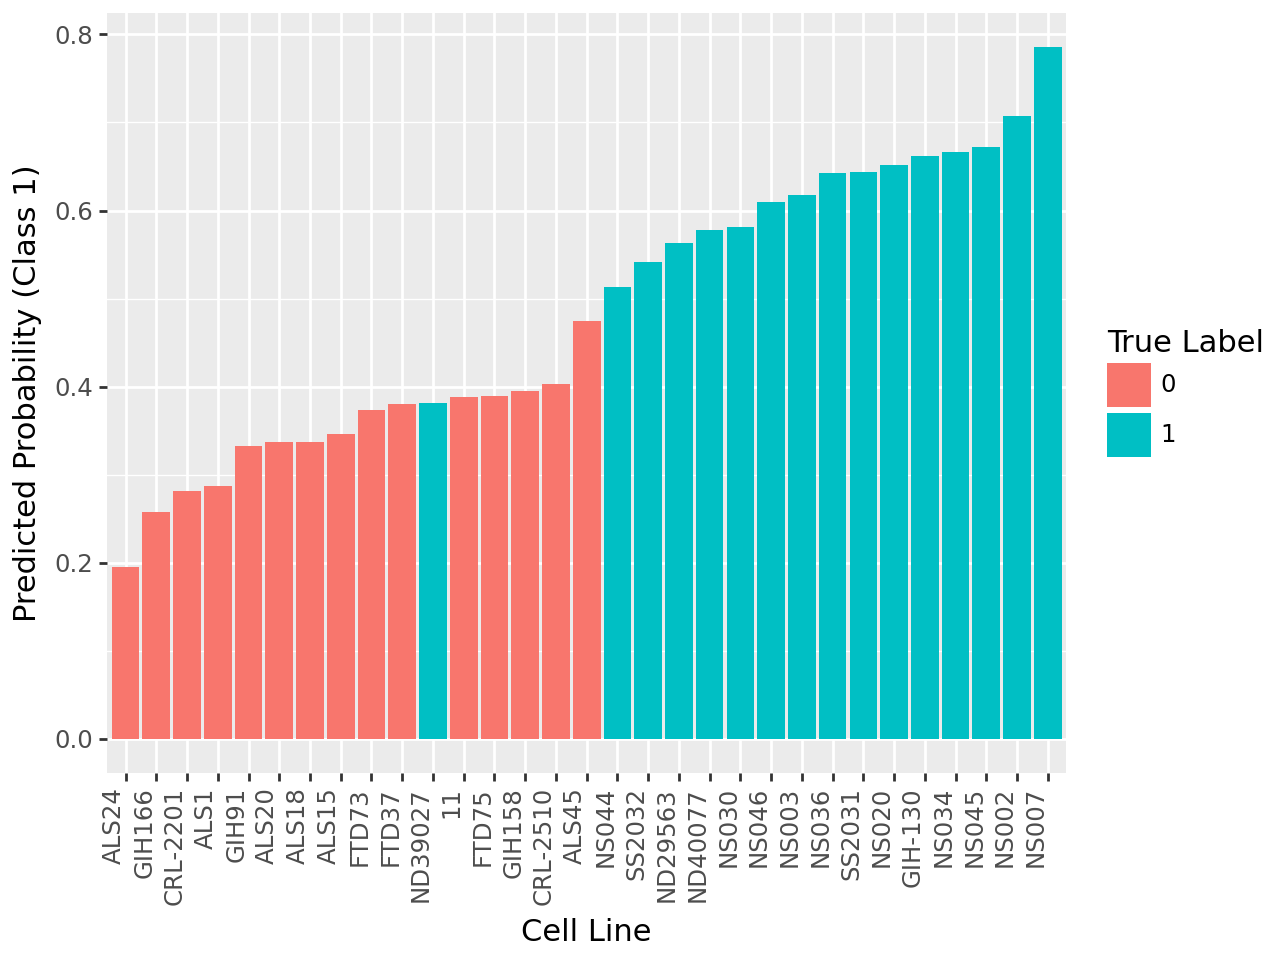

In [96]:
from plotnine import ggplot, aes, geom_bar, theme, element_text, labs

# Sort preds by predicted probability (Class_1) in ascending order
preds = preds.sort_values(by='Class_1', ascending=True)
preds['CellLines'] = pd.Categorical(preds['CellLines'], categories=preds['CellLines'], ordered=True)

# Convert True column to string for coloring
preds['True_str'] = preds['True'].astype(str)

# Create barplot
(
    ggplot(preds, aes(x='CellLines', y='Class_1', fill='True_str')) +
    geom_bar(stat='identity') +
    theme(axis_text_x=element_text(rotation=90, hjust=1)) +
    labs(x='Cell Line', y='Predicted Probability (Class 1)', fill='True Label')
)

In [97]:
line_head = model.line_head
gamma = line_head.batch_norm.weight  # shape: (in_features,)
gamma_expanded = gamma.unsqueeze(0).expand_as(line_head.fc.weight)
feature_weight = (line_head.fc.weight * gamma_expanded).abs()

print(feature_weight.shape)
print(model.antibodies)
print(f"Group1: {feature_weight[0, :32].sum().item():.4f}")
print(f"Group2: {feature_weight[0, 32:64].sum().item():.4f}")
print(f"Group3: {feature_weight[0, 64:].sum().item():.4f}")

print(f"Group1: {feature_weight[1, :32].sum().item():.4f}")
print(f"Group2: {feature_weight[1, 32:64].sum().item():.4f}")
print(f"Group3: {feature_weight[1, 64:].sum().item():.4f}")


torch.Size([2, 96])
['COX IV/Galectin3/atubulin', 'FUS/EEA1', 'HSP70/SOD1']
Group1: 1.6806
Group2: 1.8453
Group3: 1.5116
Group1: 1.9873
Group2: 1.8937
Group3: 1.4044
